In [ ]:
"""
v4 파일에서 불필요한 부분을 제거하고, 꼭 필요한 코드만 남겨놓은 버전
"""

In [1]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import hallym_utils as hu

In [2]:
"""
각종 경로 설정하기
"""
version = '4'

# 이미지 파일로 저장된, 도로 사진 : 입력
dir_path_img_frames_read = 'resource/set1/frames_in/'
if os.path.isdir(dir_path_img_frames_read) == False:
    assert False, '입력용 이미지가 저장된 폴더를 찾을 수 없습니다.'

# 여기 구현된 알고리즘으로 차선 탐지가 된 도로 사진을 저장할 폴더 : 출력
dir_path_img_frames_write = 'resource/set1/frames1_out-v' + version + '/'
if os.path.isdir(dir_path_img_frames_write) == False:
    os.mkdir(dir_path_img_frames_write)  # 디렉토리가 존재하지 않으면 생성
    
print(dir_path_img_frames_write , ' 폴더에 결과물을 저장합니다.')

# 차선 탐지가 된 도로 사진을 동영상으로 만들어서 저장할 결과물
dir_path_video_out = 'resource/set1/'
video_out_filename = 'set1-output-v' + version + '.mp4'
print(video_out_filename, ' 동영상 파일이 생성될 것 입니다.')

# github에 업로드 할 이미지를 저장해 두기 위한 폴더
dir_important_imgs = 'v' + version + '-out-imgs'
if os.path.isdir(dir_important_imgs) == False:
    os.mkdir(dir_important_imgs)  # 폴더가 존재하지 않으면 생성.

print(dir_important_imgs, ' 폴더에 샘플 이미지를 저장합니다.')

resource/set1/frames1_out-v4/  폴더에 결과물을 저장합니다.
set1-output-v4.mp4  동영상 파일이 생성될 것 입니다.
v4-out-imgs  폴더에 샘플 이미지를 저장합니다.


In [3]:
"""
주요 파라미터 설정하기
"""

"""
입력으로 들어오는 사진의 크기가, 내가 원하는 크기가 아닐 수 있다. 이를 대비하여 목표로 하는(target) 사진 크기를
미리 정해놓고, 만약 입력으로 들어오는 사진의 크기가 내가 원하는 크기가 아니면 resize 해서 사진 크기를 변경하자
"""
target_height = hu.target_height  # 영상의 폭
target_width = hu.target_width  # 영상의 높이

half_height = round(target_height / 2)  # 영상의 중심 높이
partial_height = round(target_height / 5) * 3

# height를 기준으로, 어느 높이에서 차선의 중앙을 계산할지, 
# 그리고 사진의 어느 높이에서 내 차의 중앙을 계산할지를 정하는 상수
center_lane_height = round(target_height * 0.7)   
center_myCar_height = round(target_height * 0.95)  # 이것은 사진 바닥에 가까울 수록 좋다.

"""
Frame mask 라는 것을 만들어서, 이미지에 덮어 씌운 다음에 mask 밖의 그림은 다 지워버리고 
mask 내부의 그림만 이용해서 차선을 탐지할 것이다. 이때 frame mask 크기를 얼마로 할 것인지를
설정하기 위해서 frame 왼쪽의 하단, 상단, 그리고 frame 오른쪽의 상단, 하단의 좌표를
아래와 같이 설정하였다.
"""
mask_left_bottom = hu.mask_left_bottom
mask_left_top = hu.mask_left_top
mask_right_top = hu.mask_right_top
mask_right_bottom = hu.mask_right_bottom

# 다항식에 맞춰서 fitting 할때, 몇차 다항식을 쓸건지?
poly_degree = 1
print(str(poly_degree), ' 차 다항식에 fitting 합니다.')

1  차 다항식에 fitting 합니다.


In [4]:
"""
Read Video Frames
비디오 : https://www.youtube.com/watch?reload=9&v=KWJaBJYJIjI
Frames : 비디오 촬영 영상을 연속된 이미지로 변경 해 놓은 것 (사진파일 다수)

비디오를 직접 입력으로 받지 않고, 비디오를 사진으로 변환한 다음에
사진 파일을 입력으로 받아서 처리한다.
"""

col_images = hu.read_image_frames(dir_path_img_frames_read, target_height, target_width)


num images read :  1108
image shape :  270 480
done


In [5]:
# create a zero array
# image frame중에서 아무거나 고르면 된다. 그래서 0번 인덱스를 사용했다.
# 아무 이미지나 골라서, width와 height만 가져오는 것이기 때문에 아무 이미지나 골라도 ok
stencil = np.zeros_like(col_images[0][:,:,0])

# specify coordinates of the polygon
# 촬영한 영상에 따라서 다각형의 형태를 조절할 필요가 있겠다.
polygon = np.array([mask_left_bottom, mask_left_top, mask_right_top, mask_right_bottom])  # v1에서 사용한 값

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

#plt.figure(figsize=(10,10))
#plt.imshow(stencil, cmap= "gray")
#plt.show()
print('done')

done


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  6
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  41
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  66
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  72
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  83
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  147
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  155
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  168
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  181
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  194
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  199
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  207
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  280
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  286
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  353
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  359
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  365
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  371
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  377
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  383
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  415
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  428
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  447

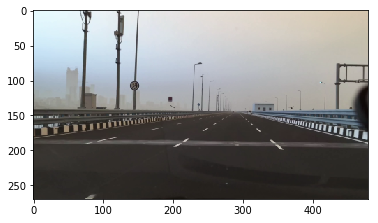

Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1002
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1079
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1080
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1081
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1082
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1083
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1084
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1085
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1086
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1087
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1088
Type Error가 발생했습니다.
Error at INDEX :  1089


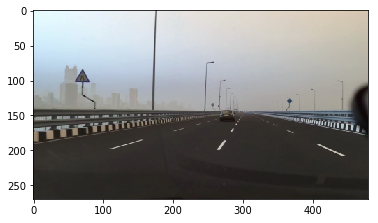

Type Error가 발생했습니다.
Error at INDEX :  1090


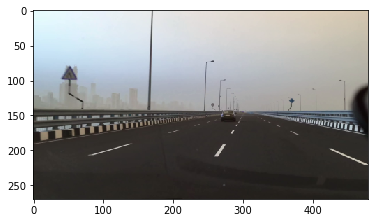

Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1091
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1092
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1093
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1094
Type Error가 발생했습니다.
Error at INDEX :  1095


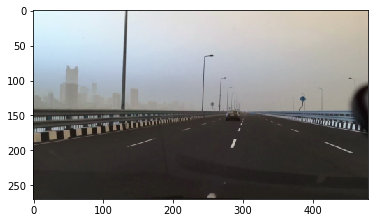

Type Error가 발생했습니다.
Error at INDEX :  1096


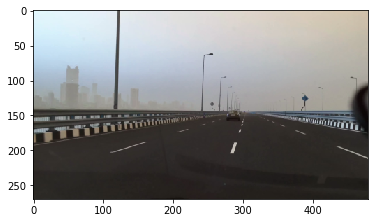

Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1097
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1098
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1099
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1100
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1101
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1102
Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1103
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1105
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1106
Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at :  1107

done, processed image count :  1108


In [6]:
"""
모든 사진 프레임에 차선탐지 알고리즘 적용
"""
cnt = 0

y_value_stepsize = 3
y_values = np.arange(partial_height, target_height, y_value_stepsize)

prev_left_lane = hu.frame_mask_lane(mask_left_bottom, mask_left_top)
prev_right_lane = hu.frame_mask_lane(mask_right_bottom, mask_right_top)

for img in tqdm_notebook(col_images):  # 각각의 도로 사진에 대해서...
    masked = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)  # frame mask 적용하기
    ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)  # image thresholding 적용하기
    lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
    dmy = img.copy()  # 원본 이미지 복사본 만들어서, 그 위에다가 탐지한 선을 그리기

    # Plot detected lines : 탐지한 선을 그리기!
    left_x, left_y, right_x, right_y = [], [], [], []
    
    try:
        for line in lines:  # 사진에서 탐지한 모든 Hough line에 대해서...
            x1, y1, x2, y2 = line[0]
            curr_slope = (x2 - x1) / (y2 - y1)  # 탐지한 차선의 경사를 계산하기
            if curr_slope < 0 :  # 기울기가 음수이면 왼쪽차선이다! 좌표계 기준이 다름.
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
            elif curr_slope > 0:  # 기울기가 양수이면 오른차선이다! 좌표계 기준이 다름.
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
            else:
                assert False
            
            # Hough 결과를 그림에 표시
            cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
  
        #draw_left, draw_right = False, False
    
        # 왼쪽 차선 그리기. x와 y를 일부러 반대로 넣었음.
        if len(left_x) > 0:  # 왼쪽 차선을 Hough 가 탐지했다면...
            left_func = np.polyfit(left_y, left_x, poly_degree)
            left_lane = np.poly1d(left_func)
            left_xs = left_lane(y_values)
            prev_left_lane = left_lane
        else:  # 왼쪽 차선을 Hough 가 탐지 못했어!!!
            print('Hough가 왼쪽 차선 탐지 못해서 직전 차선 사용 ... at : ', cnt)
            left_lane = prev_left_lane
            left_xs = left_lane(y_values)
        
        # 오른쪽 차선 그리기. x와 y를 일부러 반대로 넣었음.
        if len(right_x) > 0:  # 왼쪽 차선을 Hough 가 탐지했다면...
            right_func = np.polyfit(right_y, right_x, poly_degree)
            right_lane = np.poly1d(right_func)
            right_xs = right_lane(y_values)
            prev_right_lane = right_lane
        else:  # 왼쪽 차선을 Hough 가 탐지 못했어!!!
            print('Hough가 오른쪽 차선 탐지 못해서 직전 차선 사용 ... at : ', cnt)
            right_lane = prev_right_lane
            right_xs = right_lane(y_values)
            
        # plot frame
        curr_fig = plt.figure(figsize=(10,10))
        plt.imshow(dmy, cmap= "gray")
        plt.plot(left_xs, y_values, 'y*')
        plt.plot(right_xs, y_values, 'y*')
            
        # 차선의 중앙을 계산
        left_center_x = left_lane(center_lane_height)
        right_center_x = right_lane(center_lane_height)
        center_lane_x = left_center_x + round( (right_center_x - left_center_x) / 2 )
        # 내 차의 중간을 계산
        center_myCar_x = round(target_width / 2)

        plt.plot(center_lane_x, center_lane_height, 'r+', markersize=12)  # 차선의 중앙을 표시
        plt.text(10,20, '+ : center of both lanes', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        if center_lane_x < center_myCar_x:
            msg = 'Move to the LEFT!!'                
        elif center_lane_x > center_myCar_x:
            msg = 'Move to the RIGHT!!'                
        else:
            msg = 'I am at the CENTER!!'

        plt.text(180,100, msg, fontsize=20, bbox=dict(facecolor='yellow', alpha=0.5))
        
        plt.plot(center_myCar_x, center_myCar_height, 'gx', markersize=12)  # 내 차의 중앙을 표시
        plt.text(10,40, 'x : center of my car', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))    
        plt.savefig(dir_path_img_frames_write+str(cnt)+'.png')  # 사진을 파일로 저장
        plt.close(curr_fig)  # Notebook에 출력하면 너무 많아서.. 출력 금지!
        
    except TypeError: 
        cv2.imwrite(dir_path_img_frames_write+str(cnt)+'.png',img)  # 원본 그림 저장
        """
        오류가 언제, 왜 발생하는지 분석이 안되서, 일단은 그냥 무시하는 것으로...
        """
        print('Type Error가 발생했습니다.')
        print('Error at INDEX : ', cnt)
        plt.imshow(dmy)
        plt.show()        
        #assert False, "Type Error 가 발생했습니다."

    cnt+= 1

print('done, processed image count : ', cnt)

In [7]:
"""
차선 탐지된 이미지를 묶어서 비디오로 만들기
"""
hu.make_video_from_images(dir_path_img_frames_write, dir_path_video_out, video_out_filename)
print('done')


done


In [ ]:
# THE END